In [1]:
from utils import *
import numpy as np
import networkx as nx
from tqdm import tqdm
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

* Plot percentage of edges in each network (tram vs subway vs bus, etc)
* Plot degree distribution; check small world property, if close to erdos etc


Plot a single city's route percentages

In [3]:
all_cities = list_cities()
combined_graphs = [load_graph(city, "combined") for city in all_cities]

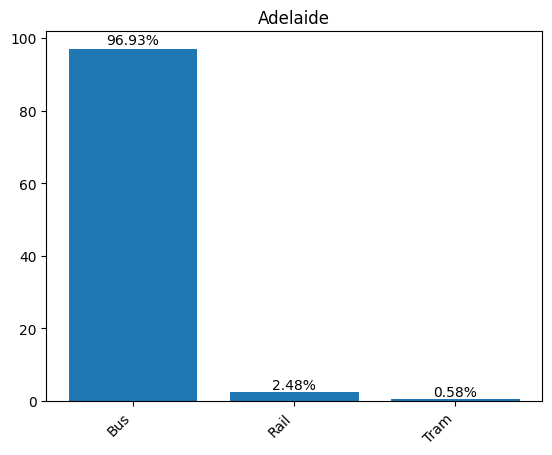

In [4]:
plot_route_percentages('adelaide')

Plot all cities' route percentages in a single plot

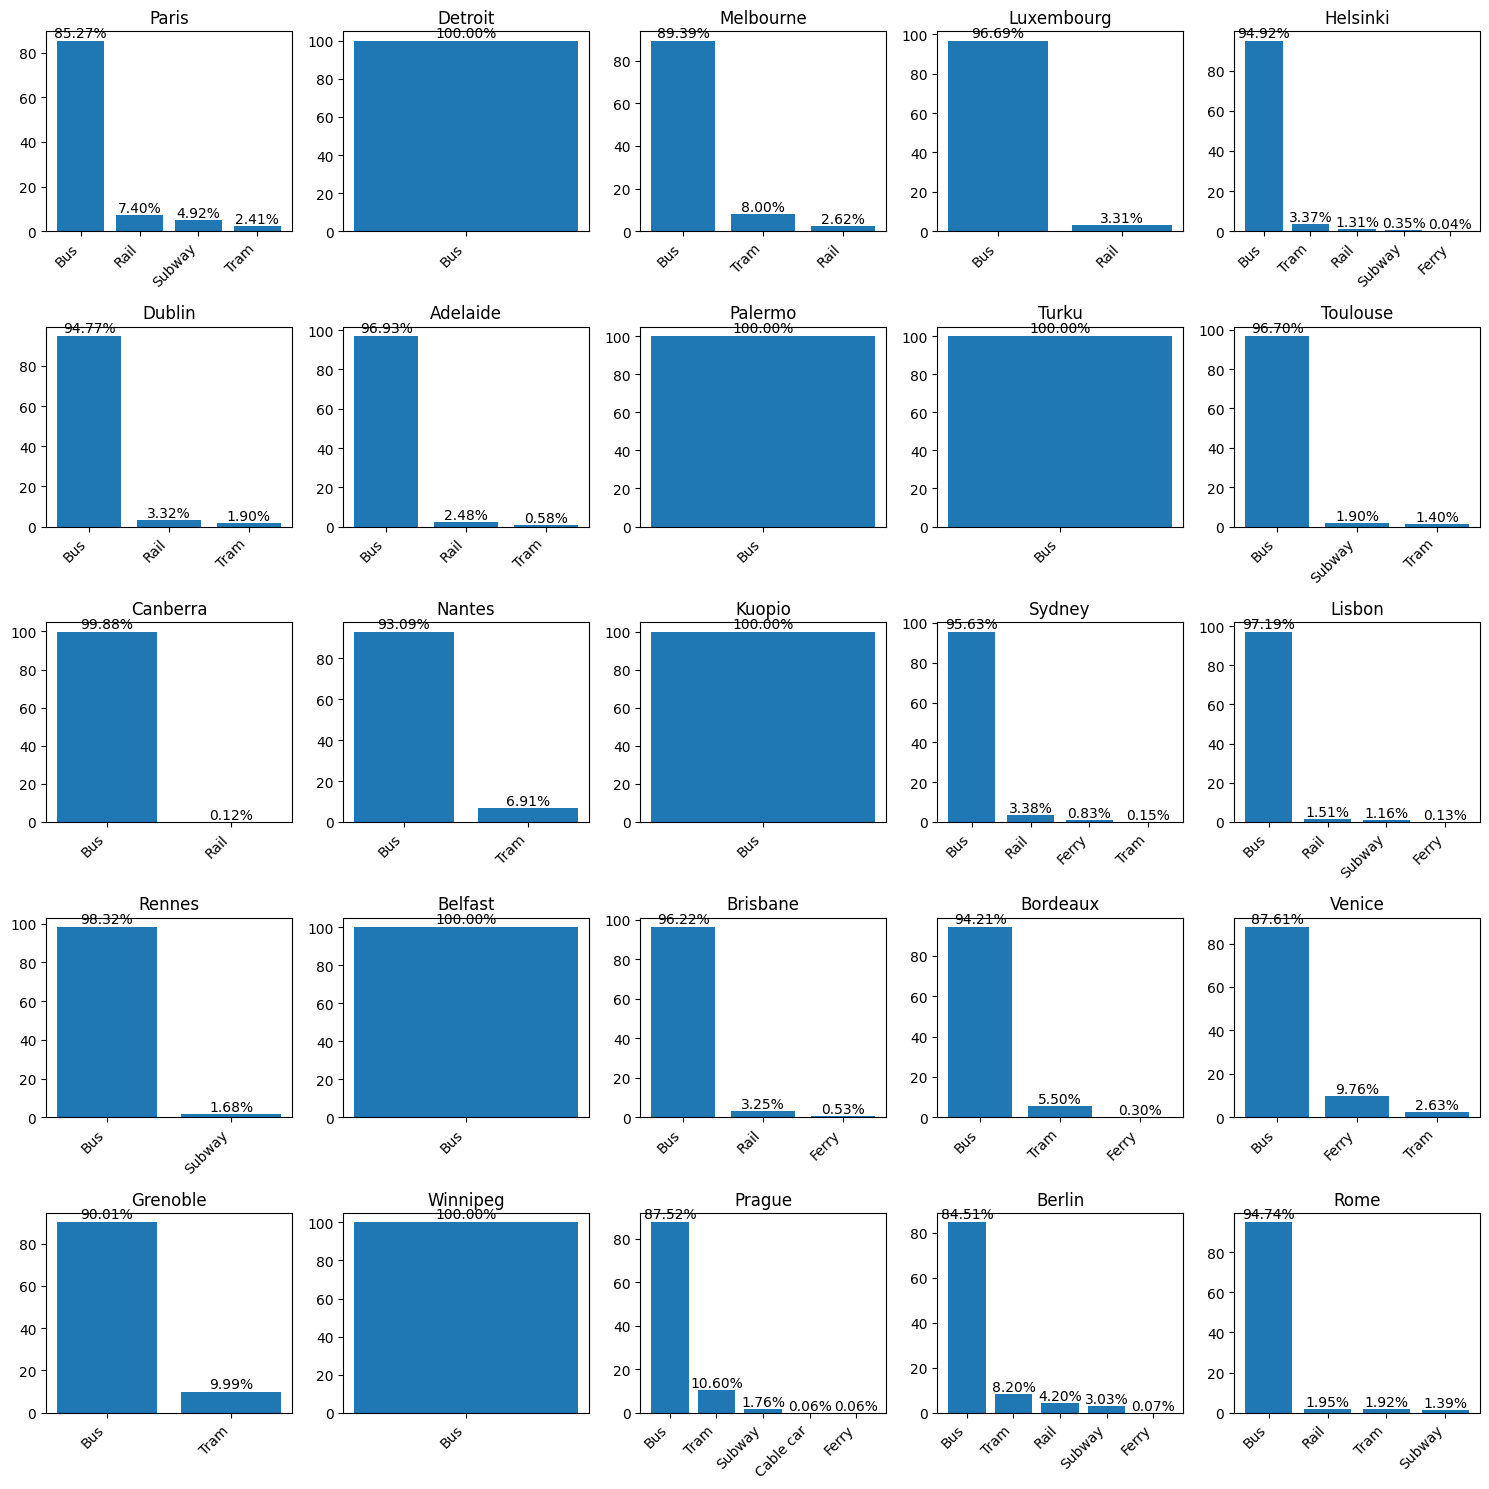

In [5]:
# Get the list of cities
cities = list_cities()

# Create a 5x5 subplot grid
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Plot route percentages for each city
for ax, city, graph in zip(axs.flatten(), cities, combined_graphs):
    plot_route_percentages(city, graph, ax)

plt.tight_layout()
plt.show()


Plot a single city's degree distribution

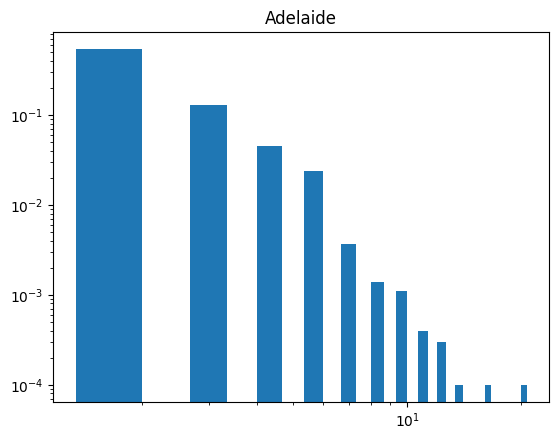

In [6]:
plot_degree_distribution('adelaide')

Plot all cities' degree distributions in a single plot

In [7]:
max_degrees = [max(g.degree(), key=lambda x: x[1])[1] for g in combined_graphs]
print("Max degree:", max(max_degrees))


Max degree: 36


Power law distribution, typical of real-world networks, gamma determines the slope, is correct, but the C param varies per network mode

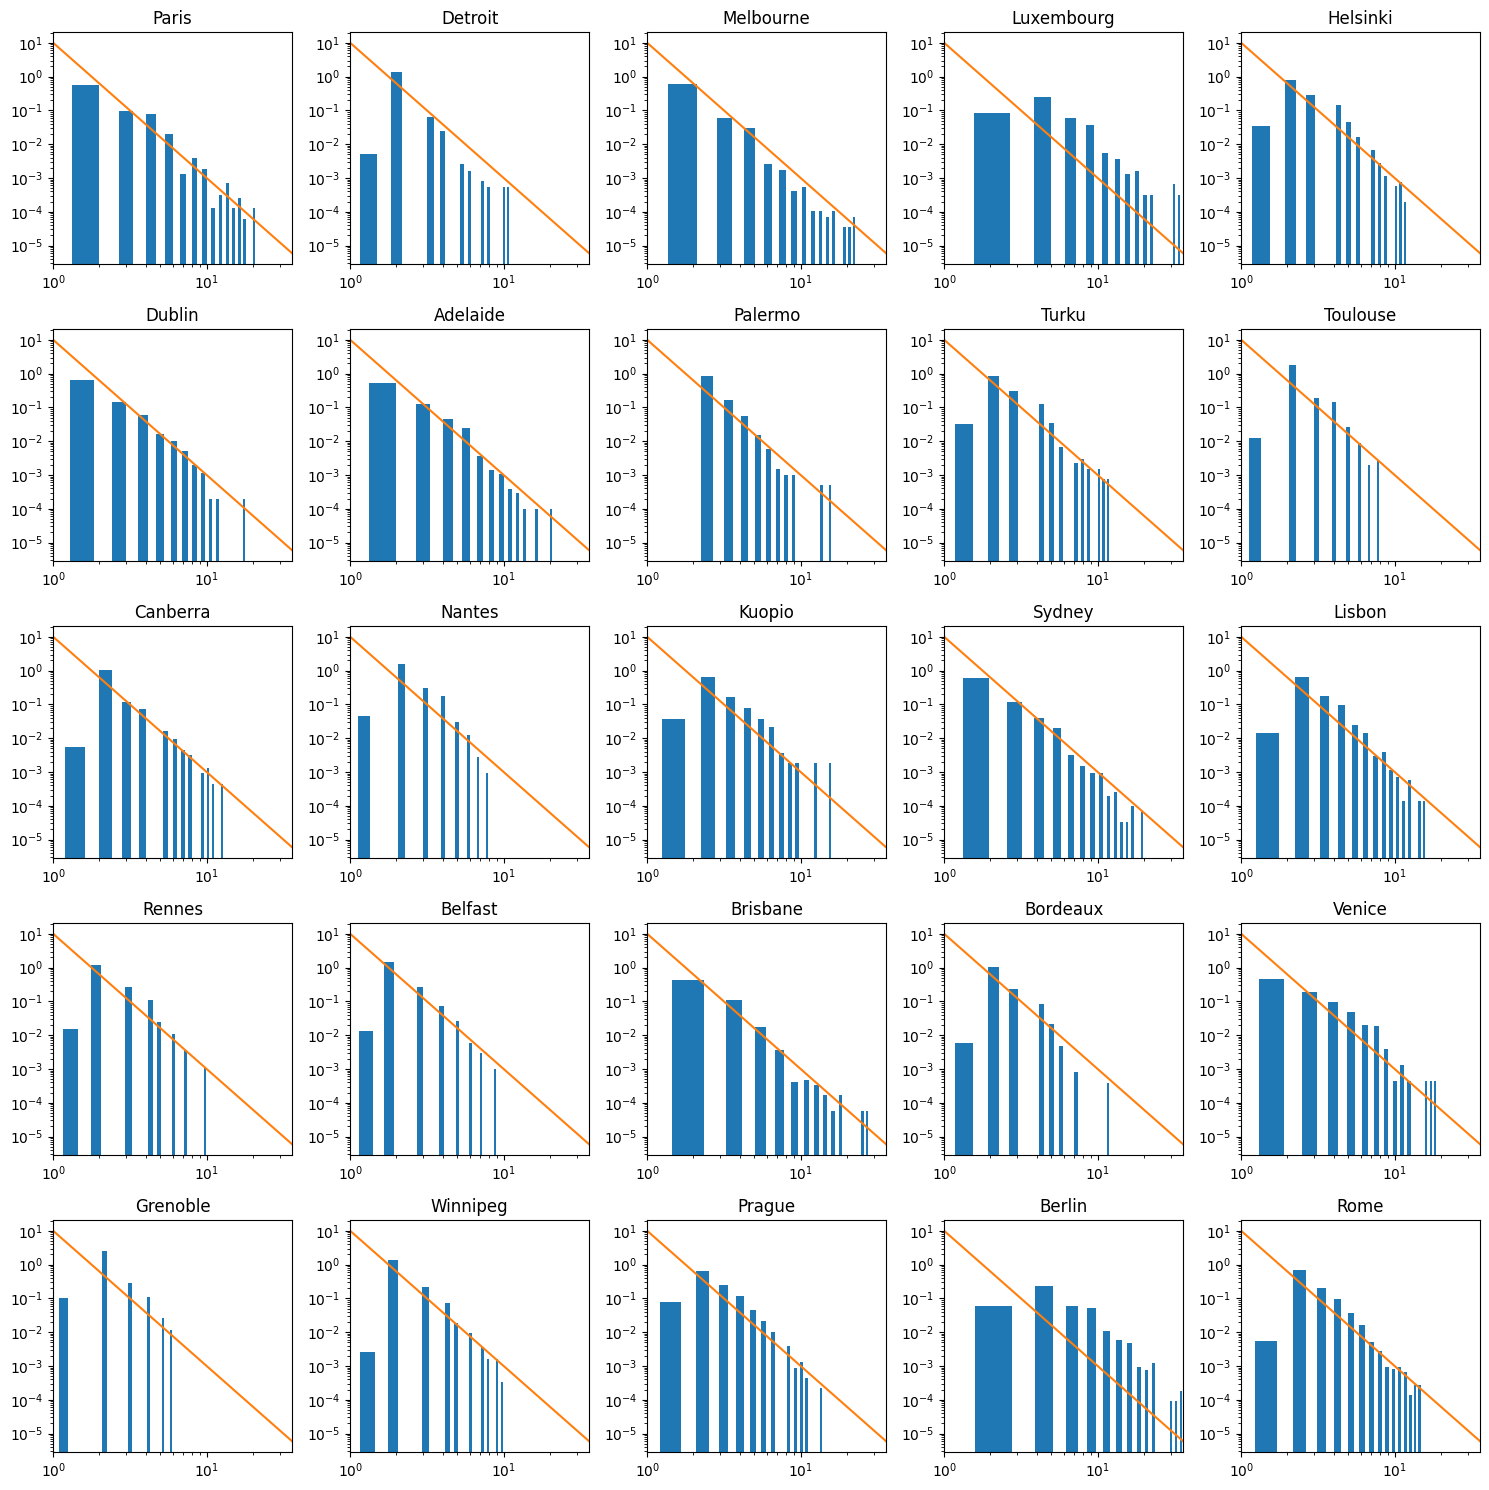

In [8]:
# Create a 5x5 subplot grid
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Plot route percentages for each city
for ax, city, graph in zip(axs.flatten(), cities, combined_graphs):
    ax.set_xlim(1, 36)
    plot_degree_distribution(
        city=city, 
        G=graph, 
        ax=ax,
        x_scale="log",
        y_scale="log"
        )
    x = np.linspace(1, 36, 100)
    C = 10
    gamma = -4
    y = C * (x ** gamma)
    ax.plot(x, y)

plt.tight_layout()
plt.show()

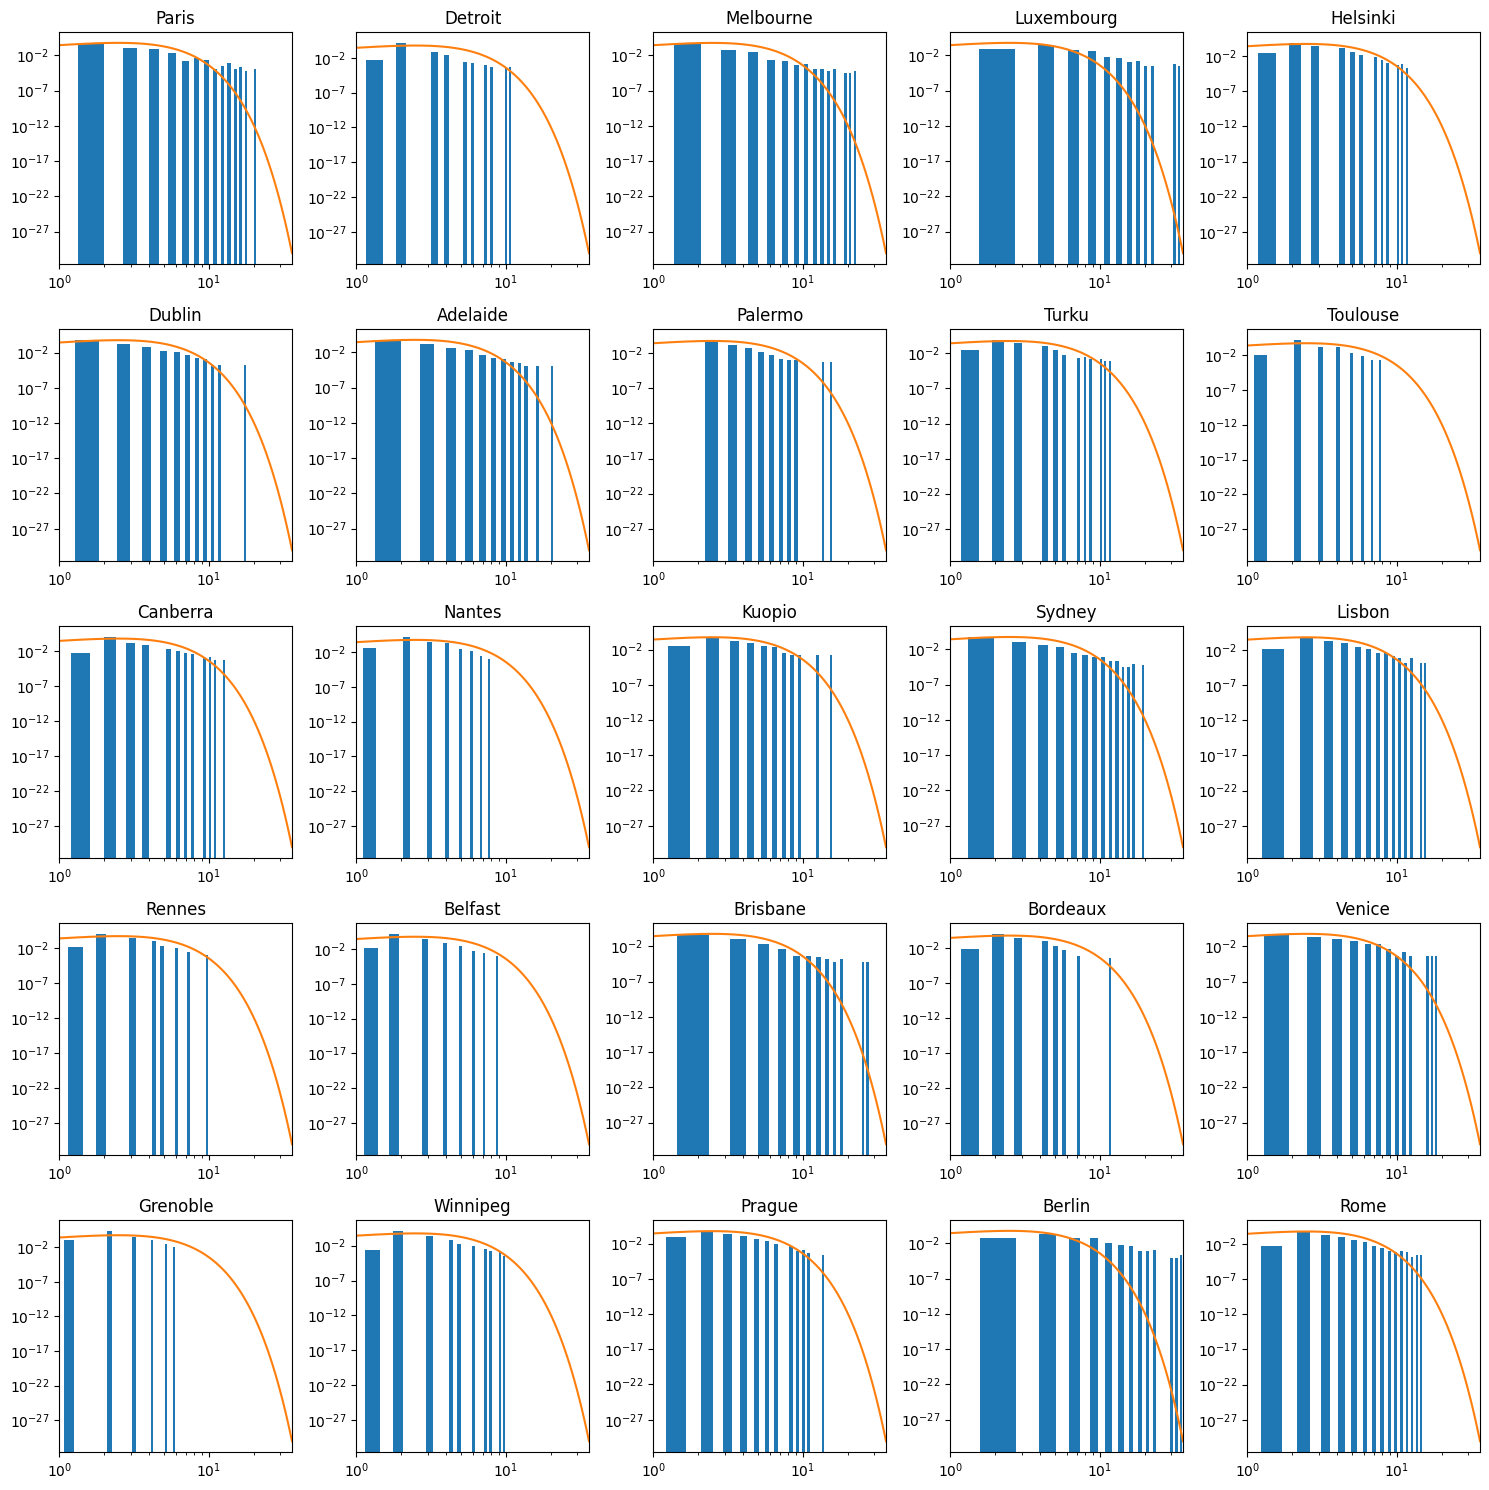

In [9]:
# Create a 5x5 subplot grid
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Plot route percentages for each city
for ax, city, graph in zip(axs.flatten(), cities, combined_graphs):
    ax.set_xlim(1, 36)
    plot_degree_distribution(
        city=city, 
        G=graph, 
        ax=ax,
        x_scale="log",
        y_scale="log"
        )
    x = np.linspace(1, 36, 100)
    mu = 2
    y = poisson_density(x, mu)
    ax.plot(x, y)

plt.tight_layout()
plt.show()

## Sparsity

In [ ]:
for city, graph in zip(cities, combined_graphs):
    n_edges = graph.number_of_edges()
    n_vertices = graph.number_of_nodes()
    max_n_edges = n_vertices * (n_vertices - 1)  # Recall we have a directed graph
    print(city.capitalize(), ":")
    print("\tNum edges:", n_edges)
    print("\tMax num edges:", max_n_edges)
    print(f"\tPercentage of edges present: {n_edges / max_n_edges * 100 :.3f}")
    print("---")

In [ ]:
"""
all_statistics = {}
with tqdm(total=len(all_cities), desc="Computing graph statistics...") as pbar:
    for city, graph in zip(all_cities, combined_graphs):
        g_stats = compute_graph_main_statistics(graph)
        all_statistics[city] = g_stats
        pbar.update(1)
    
"""

all_statistics = {}

for city, graph in zip(all_cities, combined_graphs):
    fname = os.path.join('statistics', f"{city}.pkl")
    with open(fname, "rb") as f:
        g_stats = pickle.load(f)
        all_statistics[city] = g_stats


Save statistics to disk as they take long to generate:

In [ ]:
import pickle
for city, stats in all_statistics.items():
    fname = os.path.join('statistics', f"{city}.pkl")
    with open(fname, "wb") as f:
        pickle.dump(stats, f)

print("Saved statistics to disk")

Saved statistics to disk


In [ ]:
def within_half_order_of_magn(x, ref):
    upper = ref * 5
    lower = ref / 5

    return x < upper and x > lower

In [ ]:
for city in all_cities:
    stats = all_statistics[city]
    print(city.capitalize(), ":")
    print(f"\tAverage degree:  {stats['avg_in_degree']:.3f}")
    print(f"\tAverage degree squared: {stats['avg_in_deg2']:.3f}")
    print(f"\tClustering coefficient: {stats['clustering_coeff']}")
    print(f"\tClustering coeff. random network: {stats['avg_in_degree'] / stats['n']}")
    print(f"\tClustering coeff. in BA networks: {np.log(stats['n']) ** 2 / stats['n'] }")
    print(f"\tValue within 1/2 OOM of BA value: {within_half_order_of_magn(stats['clustering_coeff'], np.log(stats['n']) ** 2 / stats['n'])}")
    print(f"\tValue within 1/2 OOM of random network value: {within_half_order_of_magn(stats['clustering_coeff'], stats['avg_in_degree'] / stats['n'])}")

    print()
    print(f"\tAverage distance: {stats['avg_dist']:.3f}")
    print(f"\tAverage distance in random network: {np.log(stats['n']) / np.log(stats['avg_in_degree']) :.3f}")
    print(f"\tAverage distance in BA network: {np.log(stats['n']) / np.log(np.log(stats['n']))}")
    print("---")

Paris :
	Average degree:  1.225
	Average degree squared: 1.868
	Clustering coefficient: 0.006928130881033461
	Clustering coeff. random network: 0.00010251221092067716
	Clustering coeff. in BA networks: 0.007376040153784351
	Value within 1/2 OOM of BA value: True
	Value within 1/2 OOM of random network value: False

	Average distance: 65.658
	Average distance in random network: 46.258
	Average distance in BA network: 4.19225416229876
---
Detroit :
	Average degree:  1.047
	Average degree squared: 1.171
	Clustering coefficient: 0.00517327104956878
	Clustering coeff. random network: 0.00018416862588376093
	Clustering coeff. in BA networks: 0.013151518612359114
	Value within 1/2 OOM of BA value: True
	Value within 1/2 OOM of random network value: False

	Average distance: 121.244
	Average distance in random network: 189.689
	Average distance in BA network: 4.0079747238349634
---
Melbourne :
	Average degree:  1.115
	Average degree squared: 1.438
	Clustering coefficient: 0.005329211071953407


In [ ]:


for city, graph in tqdm(zip(all_cities, combined_graphs), desc="Extracting spectral features...", total=len(all_cities)):
    adj = nx.adjacency_matrix(get_largest_scc(graph)).todense()
    adj = np.array(adj)
    L = compute_laplacian(adj, normalize="sym")
    lam, U = spectral_decomposition(L)

    spectral_values = {
        "L": L,
        "lam": lam,
        "U": U
    }
    fname = os.path.join("spectral", city + ".pkl")
    with open(fname, "wb") as f:
        pickle.dump(spectral_values)
        

    

Extracting spectral features...:   0%|          | 0/25 [00:00<?, ?it/s]/var/folders/ch/1p97d4xj5p9c_hv0pc2sxyx40000gn/T/ipykernel_6024/2438497614.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(get_largest_scc(graph)).todense()


/Users/justindeschenaux/miniconda3/envs/networks_ml/lib/python3.8/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


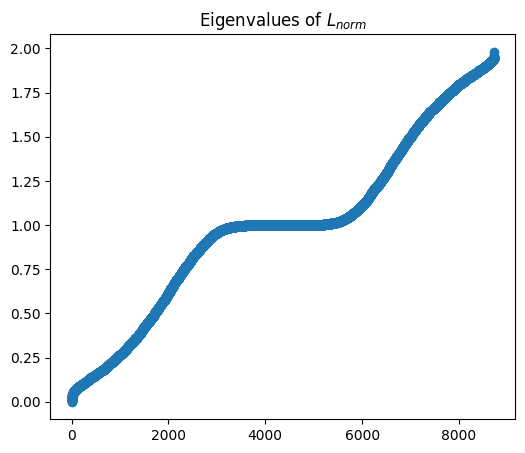

In [ ]:
plt.figure(figsize=(6, 5))
plt.scatter(np.arange(len(lam)), lam)
plt.title('Eigenvalues of $L_{norm}$')
plt.show()

Note: in/out average degree is the same because in and out degree is always the same, since all buses arriving at one stop must leave it.

### Probably better approximation by random network than scale free
* See notion doc for explanation

TODOs to confirm that we have scale-free/heavy tailed networks

TODO: once we have the statistics, compute ln(N) / ln(k) and compare with average degree -> In random networks, it should match (see lecture 3, slide 40), but probably not the case for us as we saw fat tails in degree distribution.

In course we saw for undirected graph. Maybe ask Andrej what to do about it.

Check average distannce against scale free as well (lec 4: should be ln(N) but here it's not matchint; check other graphs)

Check clustering coefficient also. Should be Ln(N) ** 2 / N